# Hedging like a Quant

Full worked example of the impact of delta hedging european options.


In [2]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

In [4]:
import datetime as dt
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

In [6]:
import yfinance as yf

In [8]:
end = dt.datetime.now()
start = dt.datetime(2020,1,1)

df = yf.download('CBA.AX', start, end)
Close = df.Close
Close.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2024-08-08    129.110001
2024-08-09    129.550003
2024-08-12    130.529999
2024-08-13    132.520004
2024-08-14    134.210007
Name: Close, dtype: float64

(0.2844442316792619, 134.2100067138672)

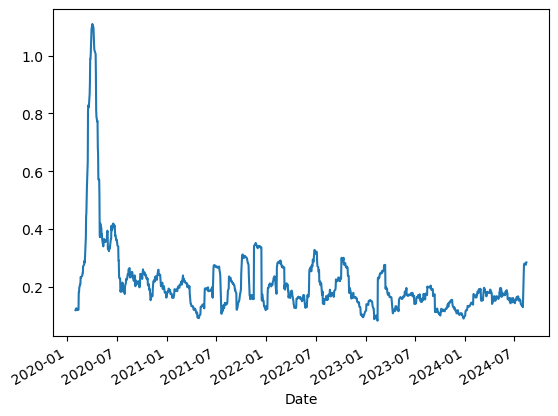

In [10]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

# Implied Volatility

In [12]:
## required for installing py_vollib
!pip install py_vollib

In [30]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

In [32]:
S0 = 102
atm_options = [
[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3]

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

In [34]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

In [36]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)

def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan

def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

In [38]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

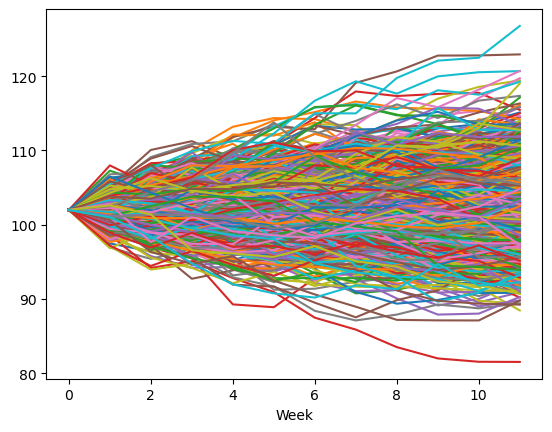

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.27,102.60,101.62,101.14,102.09,100.73,101.74,99.94,103.09,...,106.49,101.39,101.17,98.93,101.22,103.78,102.79,101.05,102.61,101.02
2,0.18,102.19,101.79,100.44,101.10,100.57,103.23,100.72,101.37,104.00,...,104.32,100.89,102.52,96.94,101.34,103.53,97.66,101.38,101.39,98.45
3,0.16,104.00,102.96,97.44,100.01,99.61,102.26,105.24,103.21,103.88,...,102.22,100.91,103.78,98.92,101.49,104.87,101.10,101.26,96.57,94.81
4,0.14,105.10,101.42,98.40,99.29,97.58,102.12,100.71,104.79,104.56,...,100.27,100.99,103.75,97.05,101.02,104.79,99.13,100.69,96.14,91.98
5,0.12,105.15,102.19,100.80,101.42,97.82,101.89,100.95,105.80,103.70,...,100.08,100.14,103.13,97.15,101.60,105.73,98.59,99.51,95.68,90.77
6,0.10,104.81,105.93,102.23,98.46,95.47,100.44,102.09,108.92,103.99,...,102.36,100.73,100.40,96.09,101.57,105.47,98.21,100.17,97.13,90.21
7,0.08,107.70,105.81,103.00,97.60,99.69,103.40,99.93,109.43,102.95,...,102.28,100.48,99.79,97.65,100.62,105.06,100.19,102.55,95.10,91.85
8,0.06,109.71,108.36,98.80,96.74,98.75,103.90,99.76,110.19,102.88,...,102.66,99.84,99.14,96.38,102.42,106.16,101.18,105.62,94.38,91.35


In [40]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)

St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

## Build up delta hedging dataframe with specific factors:
 - delta
 - total delta positions
 - number of adjustments
 - adjustment cashflow
 - interest on adjustments

 We can then sum the columns over the 11 weeks of delta heding and calculate the carry on options, carry on stock, option p&l, stock p&l and adjustment p&l and interest earned on adjustments.

In [42]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']

    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])

    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)


/var/folders/gf/fqc5rxxs2txgngf6xz144s4c0000gp/T/ipykernel_26055/435337003.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
/var/folders/gf/fqc5rxxs2txgngf6xz144s4c0000gp/T/ipykernel_26055/435337003.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
/var/folders/gf/fqc5rxxs2txgngf6xz144s4c0000gp/T/ipykernel_26055/435337003.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

## Delta Hedging P&L
- sum all contributions for Total Cashflow for each simulation

In [44]:
Dynamic_Hedging_Results.sum(axis=0)


0       28.708493
1       -6.681507
2      -80.511507
3       11.308493
4       70.608493
          ...    
995     74.448493
996   -114.271507
997     23.598493
998    -47.691507
999    -37.151507
Length: 1000, dtype: float64

In [46]:
Dynamic_Hedging_Results.loc['TOTAL CASHFLOW'] = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Dynamic hedging results,,,,,,,,,,,,,,,,,,,,,
Original Option P&L,-247.500000,-343.500000,258.500000,258.500000,258.500000,-293.500000,258.500000,-119.500000,258.500000,45.500000,...,258.500000,205.500000,258.500000,258.500000,258.500000,-67.500000,258.500000,-85.500000,258.500000,258.500000
Original Stock P&L,273.240000,325.080000,-401.760000,-394.200000,-6.480000,298.080000,-153.900000,204.120000,-70.740000,115.020000,...,-145.260000,28.620000,-435.780000,-370.980000,-87.480000,176.040000,-254.340000,185.760000,-609.660000,-526.500000
Adjustment P&L,36.860000,43.370000,76.870000,158.220000,-167.770000,51.730000,-153.850000,-48.530000,-71.630000,-119.490000,...,-123.020000,-90.650000,187.370000,105.450000,-20.950000,0.320000,-102.720000,-51.280000,311.420000,236.060000
Carry (interest) on options,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,...,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151
Carry (interest) on stock,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,...,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658
Interest on Adjustments,-10.880000,-8.620000,8.890000,11.800000,9.370000,-3.390000,6.110000,-10.910000,-4.960000,-10.450000,...,0.880000,7.710000,6.060000,16.160000,3.510000,-11.400000,7.300000,-2.370000,15.060000,17.800000
TOTAL CASHFLOW,28.708493,-6.681507,-80.511507,11.308493,70.608493,29.908493,-66.151507,2.168493,88.158493,7.568493,...,-31.911507,128.168493,-6.861507,-13.881507,130.568493,74.448493,-114.271507,23.598493,-47.691507,-37.151507


## Visualise distributions
 - hedging
 - static hedge (at entry only)
 - no delta heding

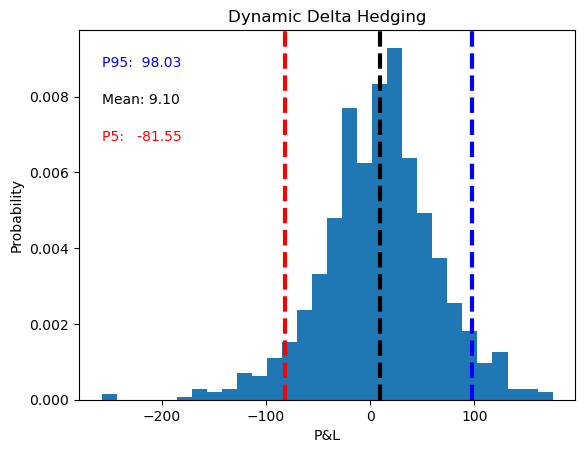

In [48]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

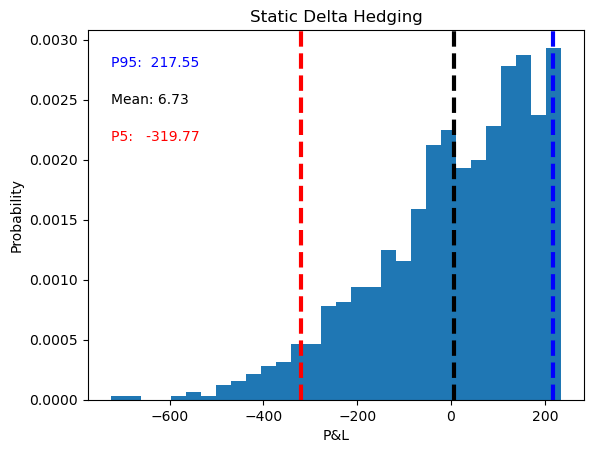

In [33]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

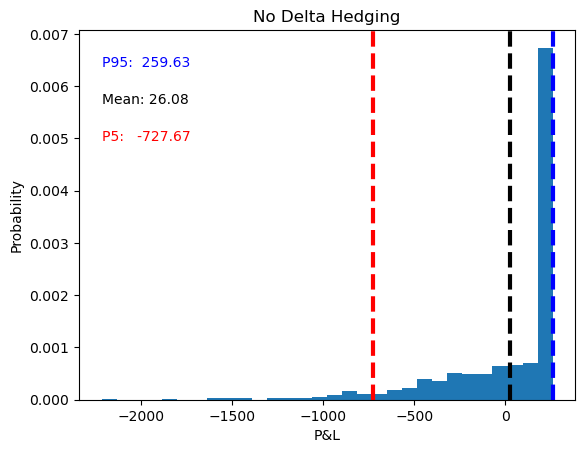

In [50]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')